# Emotions Detection in Text

# Corr ected

In [ ]:
import pandas as pd
import numpy as np
import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier

In [ ]:
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# ----------- Load Data ----------
df = pd.read_csv("/content/Emotion_dataset.csv")

print("Original shape:", df.shape)

Original shape: (33790, 2)


In [ ]:
# ----------- Detect exact duplicate ----------
duplicate_count = df.duplicated().sum()
print("Exact duplicate rows:", duplicate_count)

Exact duplicate rows: 3627


In [ ]:
exact_duplicates_grouped = (
    df[df.duplicated(keep=False)]
    .assign(dup_group=lambda x: x.groupby(list(df.columns)).ngroup())
    .sort_values("dup_group")
)

exact_duplicates_grouped

,Emotion,Text,dup_group
32305,anger,And why are you yarning now ? Are you bored ?,0
1356,anger,And why are you yarning now ? Are you bored ?,0
8632,anger,Apparently I was furious I had not been consu...,1
14853,anger,Apparently I was furious I had not been consu...,1
1410,anger,At least if there 's a human being there you ...,2
...,...,...,...
9282,surprise,To Twitter &amp; Facebook Police- Santa Clause...,2589
26094,surprise,To Twitter &amp; Facebook Police- Santa Clause...,2589
1490,surprise,"Van Spanje tot down under staat een klaar, ge...",2590
33304,surprise,"Van Spanje tot down under staat een klaar, ge...",2590


In [ ]:
# ----------- Remove exact duplicates ----------
df = df.drop_duplicates().reset_index(drop=True)

In [ ]:
# ----------- Recheck exact duplicate ----------
duplicate_count = df.duplicated().sum()
print("Exact duplicate rows:", duplicate_count)

Exact duplicate rows: 0


In [ ]:
# ----------- Detect label conflicts ----------
conflicts = (
    df.groupby("Text")["Emotion"]
    .nunique()
    .reset_index()
)

conflicts = conflicts[conflicts["Emotion"] > 1]
print("Label conflicts found:", conflicts.shape[0])

Label conflicts found: 50


In [ ]:
# ----------- Show label conflicts ----------
conflict_summary = (
    df[df["Text"].isin(conflicts["Text"])]
    .groupby("Text")["Emotion"]
    .apply(list)
    .reset_index(name="Labels")
)

conflict_summary

,Text,Labels
0,All right .,"[joy, neutral]"
1,And why are you yarning now ? Are you bored ?,"[anger, neutral]"
2,Bye .,"[neutral, joy]"
3,Certainly .,"[joy, neutral]"
4,Certainly not .,"[sadness, anger]"
5,Don't mixing #cosmetic brands. If it works fo...,"[fear, neutral]"
6,Frightened ? You must be joking .,"[neutral, fear]"
7,Great .,"[joy, neutral]"
8,I don't think you really want to hear about i...,"[anger, sadness]"
9,I have been looking forward to this performan...,"[sadness, anger]"


In [ ]:
# ----------- Resolve label conflicts ----------
df = (
    df.groupby("Text")["Emotion"]
    .agg(lambda x: x.value_counts().index[0])
    .reset_index()
)

This approach is called:

Mode-based label conflict resolution

It is commonly used when:

annotation noise exists

multiple annotators label the same data

majority vote is assumed to be correct

Advantages

Simple

Deterministic

Preserves dataset size

No label leakage

Trade-off

Minority labels are discarded (acceptable unless rare classes are critical)


what if only two such samples exist with labels sadness and disgust there is 50% chance for each what would be the label ?
In that case, one of the two labels will be chosen arbitrarily, because value_counts() breaks ties based on internal ordering (typically first occurrence / sort order), not on probability.

In [ ]:
# ----------- Recheck label conflicts ----------
conflicts = (
    df.groupby("Text")["Emotion"]
    .nunique()
    .reset_index()
)

conflicts = conflicts[conflicts["Emotion"] > 1]
print("Label conflicts found:", conflicts.shape[0])

Label conflicts found: 0


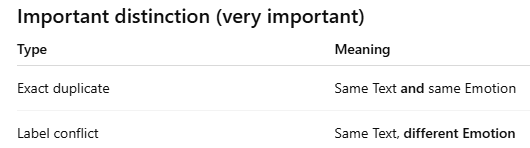

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30111 entries, 0 to 30110
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     30111 non-null  object
 1   Emotion  30111 non-null  object
dtypes: object(2)
memory usage: 470.6+ KB


In [ ]:
# ----------- Class distribution ----------
class_distribution = df["Emotion"].value_counts()
print("\nClass Distribution:\n", class_distribution)

imbalance_ratio = class_distribution.max() / class_distribution.min()
print("\nImbalance Ratio:", round(imbalance_ratio, 2))


Class Distribution:
 Emotion
joy         10449
sadness      6168
fear         4260
surprise     4015
anger        3769
neutral      1450
Name: count, dtype: int64

Imbalance Ratio: 7.21


Class imbalance is partially handled using class_weight="balanced" in Logistic Regression, SVM, Random Forest, and Decision Tree. Stratified splitting ensures the test set has the same distribution. Models like NB and XGBoost do not have class weighting here, so imbalance is not handled for them.


"Given the moderate imbalance in the dataset, explicit resampling of minority classes was not used. Instead, class weights (class_weight="balanced") were applied to ensure that minority classes are properly learned by the classifiers. Oversampling was deemed unnecessary to avoid potential overfitting and maintain natural data distribution."

In [ ]:
# ----------- Text Preprocessing ----------
stop_words = set(stopwords.words("english")) - {"not", "no", "never"}
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"@\w+|#\w+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\s+", " ", text).strip()
    tokens = [
        lemmatizer.lemmatize(w)
        for w in text.split()
        if w not in stop_words
    ]
    return " ".join(tokens)

def handle_negation(text):
    words = text.split()
    negations = {"not", "no", "never"}
    result = []
    negate = False

    for w in words:
        if w in negations:
            negate = True
            continue
        if negate:
            result.append("not_" + w)
            negate = False
        else:
            result.append(w)

    return " ".join(result)

df["Clean_Text"] = df["Text"].apply(preprocess_text).apply(handle_negation)

In [ ]:
# ----------- Remove very short samples ----------
df["len"] = df["Clean_Text"].str.split().apply(len)
df = df[df["len"] > 2].drop(columns="len").reset_index(drop=True)

In [ ]:
# ----------- Encode labels ----------
X = df["Clean_Text"]
y = df["Emotion"]

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [ ]:
# ----------- Stratified split ----------
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

In [ ]:
# ----------- Verify stratification ----------

In [ ]:
# ----------- Verify stratification ----------
print("\nTrain distribution:\n", pd.Series(y_train).value_counts(normalize=True))
print("\nTest distribution:\n", pd.Series(y_test).value_counts(normalize=True))


Train distribution:
 2    0.357196
4    0.208749
1    0.145963
5    0.139689
0    0.125964
3    0.022439
Name: proportion, dtype: float64

Test distribution:
 2    0.357267
4    0.208784
1    0.145870
5    0.139770
0    0.125828
3    0.022482
Name: proportion, dtype: float64


In [ ]:
# ----------- Compute class weights ----------
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
print("\nClass Weights:", class_weights)


Class Weights: {0: np.float64(1.3231292517006803), 1: np.float64(1.1418407960199004), 2: np.float64(0.46659754411645116), 3: np.float64(7.427508090614887), 4: np.float64(0.7984067348500661), 5: np.float64(1.1931274693283427)}


In [ ]:
# ----------- Vectorizers ----------
count_vectorizer = CountVectorizer(ngram_range=(1,2), min_df=2)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,3), min_df=2)

X_train_count = count_vectorizer.fit_transform(X_train)
X_test_count = count_vectorizer.transform(X_test)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [ ]:
# # ----------- Models ----------
# # models = {
# #     "Logistic Regression": LogisticRegression(max_iter=2000, class_weight="balanced"),
# #     "SVM": LinearSVC(class_weight="balanced"),
# #     "Random Forest": RandomForestClassifier(class_weight="balanced", random_state=42),
# #     "Decision Tree": DecisionTreeClassifier(class_weight="balanced", random_state=42)
# # }

# from sklearn.calibration import CalibratedClassifierCV

# models = {
#     "Logistic Regression": LogisticRegression(max_iter=2000, class_weight="balanced"),
#     "SVM": CalibratedClassifierCV(LinearSVC(class_weight="balanced")),
#     "Random Forest": RandomForestClassifier(class_weight="balanced", random_state=42),
#     "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight="balanced")
# }


# vectorizers = {
#     "CountVectorizer": (X_train_count, X_test_count),
#     "TF-IDF": (X_train_tfidf, X_test_tfidf)
# }

In [ ]:

# from sklearn.model_selection import GridSearchCV
# import joblib

# # ----------- Hyperparameter grids ----------
# param_grids = {
#     "Logistic Regression": {
#         "C": [0.01, 0.1, 1, 10, 100],
#         "penalty": ["l2"],
#         "solver": ["lbfgs", "saga"]
#     },
#     "SVM": {
#         "base_estimator__C": [0.1, 1, 10],
#         "base_estimator__max_iter": [1000, 2000]
#     },
#     "Random Forest": {
#         "n_estimators": [100, 200, 500],
#         "max_depth": [None, 10, 20, 50],
#         "min_samples_split": [2, 5, 10],
#         "min_samples_leaf": [1, 2, 4]
#     },
#     "Decision Tree": {
#         "max_depth": [None, 10, 20, 50],
#         "min_samples_split": [2, 5, 10],
#         "min_samples_leaf": [1, 2, 4]
#     }
# }

# # ----------- Tune models for a given vectorizer ----------
# best_models = {}

# for vec_name, (X_tr, X_te) in vectorizers.items():
#     print("\nTuning models for:", vec_name)
#     best_models[vec_name] = {}

#     for model_name, model in models.items():
#         print("\nModel:", model_name)
#         grid = GridSearchCV(model, param_grids[model_name], cv=5, scoring="accuracy", n_jobs=-1)
#         grid.fit(X_tr, y_train)
#         print("Best params:", grid.best_params_)
#         print("Best CV score:", grid.best_score_)

#         best_model = grid.best_estimator_
#         best_models[vec_name][model_name] = best_model

#         # Evaluate on test set
#         y_pred = best_model.predict(X_te)
#         acc = accuracy_score(y_test, y_pred)
#         print(f"Test Accuracy: {acc:.4f}")

#         # Save tuned model
#         joblib.dump(best_model, f"{model_name}_{vec_name}.pkl")

# # Save vectorizers and label encoder
# joblib.dump(count_vectorizer, 'count_vectorizer.pkl')
# joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
# joblib.dump(label_encoder, 'label_encoder.pkl')

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import joblib

# ------------------------------
# Models (base estimators)
# ------------------------------
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, class_weight="balanced"),
    "SVM": LinearSVC(class_weight="balanced"),  # LinearSVC only for tuning
    "Random Forest": RandomForestClassifier(class_weight="balanced", random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight="balanced")
}

# ------------------------------
# Vectorizers
# ------------------------------
vectorizers = {
    "CountVectorizer": (X_train_count, X_test_count),
    "TF-IDF": (X_train_tfidf, X_test_tfidf)
}

# ------------------------------
# Hyperparameter grids
# ------------------------------
param_grids = {
    "Logistic Regression": {
        "C": [0.01, 0.1, 1, 10, 100],
        "penalty": ["l2"],
        "solver": ["lbfgs", "saga"]
    },
    "SVM": {
        "C": [0.1, 1, 10],
        "max_iter": [1000, 2000]
    },
   "Random Forest": {
    "n_estimators": [100, 200],
    "max_depth": [None, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
},
    "Decision Tree": {
        "max_depth": [None, 10, 20, 50],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4]
    }
}

# ------------------------------
# Tune models and save
# ------------------------------
best_models = {}

for vec_name, (X_tr, X_te) in vectorizers.items():
    print("\nTuning models for:", vec_name)
    best_models[vec_name] = {}

    for model_name, model in models.items():
        print("\nModel:", model_name)

        # Special handling for SVM
        if model_name == "SVM":
            # Step 1: Tune LinearSVC
            grid = GridSearchCV(model, param_grids[model_name], cv=5, scoring="accuracy", n_jobs=-1)
            grid.fit(X_tr, y_train)
            best_svc = grid.best_estimator_
            print("Best LinearSVC params:", grid.best_params_)
            print("Best CV score:", grid.best_score_)

            # Step 2: Wrap with CalibratedClassifierCV
            calibrated_svc = CalibratedClassifierCV(best_svc)
            calibrated_svc.fit(X_tr, y_train)
            best_model = calibrated_svc

        else:
            # Other models tuned normally
            grid = GridSearchCV(model, param_grids[model_name], cv=5, scoring="accuracy", n_jobs=-1)
            grid.fit(X_tr, y_train)
            best_model = grid.best_estimator_
            print("Best params:", grid.best_params_)
            print("Best CV score:", grid.best_score_)

        # Evaluate on test set
        y_pred = best_model.predict(X_te)
        acc = accuracy_score(y_test, y_pred)
        print(f"Test Accuracy: {acc:.4f}")

        # Save tuned model
        joblib.dump(best_model, f"{model_name}_{vec_name}.pkl")

        # Store in best_models dictionary
        best_models[vec_name][model_name] = best_model

# # Save vectorizers and label encoder
# joblib.dump(count_vectorizer, 'count_vectorizer.pkl')
# joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
# joblib.dump(label_encoder, 'label_encoder.pkl')

# print("\nAll models, vectorizers, and label encoder saved successfully!")
# --------------------------------
# Save EVERYTHING in one object
# --------------------------------
final_artifacts = {
    "models": best_models,                 # All tuned models
    "vectorizers": {
        "count": count_vectorizer,
        "tfidf": tfidf_vectorizer
    },
    "label_encoder": label_encoder
}

joblib.dump(final_artifacts, "all_trained_models.pkl")

print("All models, vectorizers, and label encoder saved in all_trained_models.pkl")


Tuning models for: CountVectorizer

Model: Logistic Regression
Best params: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV score: 0.5853779655089123
Test Accuracy: 0.5833

Model: SVM
Best LinearSVC params: {'C': 0.1, 'max_iter': 1000}
Best CV score: 0.5971860735387841
Test Accuracy: 0.6199

Model: Random Forest


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best CV score: 0.577274083185393
Test Accuracy: 0.5859

Model: Decision Tree
Best params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best CV score: 0.4779748480141833
Test Accuracy: 0.4854

Tuning models for: TF-IDF

Model: Logistic Regression
Best params: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV score: 0.5919135430739977
Test Accuracy: 0.5891

Model: SVM
Best LinearSVC params: {'C': 0.1, 'max_iter': 1000}
Best CV score: 0.5990157877328428
Test Accuracy: 0.6121

Model: Random Forest
Best params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best CV score: 0.5798012783370324
Test Accuracy: 0.5823

Model: Decision Tree
Best params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best CV score: 0.46259439112899214
Test Accuracy: 0.4674
All models, vectorizers, and label encoder saved in all_tr

In [ ]:
import os
from google.colab import files
if print(os.path.exists("all_trained_models.pkl")):
  if print(os.path.getsize("all_trained_models.pkl") / (1024 * 1024), "MB"):
    files.download("all_trained_models.pkl")

True


In [ ]:
# # ----------- Training & Evaluation ----------
# # results = []

# # for vec_name, (X_tr, X_te) in vectorizers.items():
# #     print("\n" + "="*70)
# #     print("Vectorizer:", vec_name)
# #     print("="*70)

# #     for model_name, model in models.items():
# #         model.fit(X_tr, y_train)
# #         y_pred = model.predict(X_te)

# #         acc = accuracy_score(y_test, y_pred)
# #         print(f"\nModel: {model_name}")
# #         print("Accuracy:", round(acc, 4))
# #         print(classification_report(
# #             y_test, y_pred,
# #             target_names=label_encoder.classes_
# #         ))

# #         results.append({
# #             "Vectorizer": vec_name,
# #             "Model": model_name,
# #             "Accuracy": acc
# #         })
# vectorizers = {
#     "CountVectorizer": (X_train_count, X_test_count),
#     "TF-IDF": (X_train_tfidf, X_test_tfidf)
# }

# import joblib
# from sklearn.metrics import accuracy_score

# results = []

# for vec_name, (X_tr, X_te) in vectorizers.items():
#     for model_name, model in models.items():
#         model.fit(X_tr, y_train)
#         y_pred = model.predict(X_te)
#         acc = accuracy_score(y_test, y_pred)
#         results.append({
#             "Vectorizer": vec_name,
#             "Model": model_name,
#             "Accuracy": acc
#         })

#         # Save model with vectorizer name to avoid conflicts
#         joblib.dump(model, f"{model_name}_{vec_name}.pkl")

# # Save vectorizers and label encoder
# joblib.dump(count_vectorizer, 'count_vectorizer.pkl')
# joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
# joblib.dump(label_encoder, 'label_encoder.pkl')

In [ ]:
# # ----------- Final Comparison ----------
# results_df = pd.DataFrame(results).sort_values("Accuracy", ascending=False)
# print("\nFINAL MODEL COMPARISON:\n")
# print(results_df)
# ----------- Final Comparison ----------
results = []

for vec_name, (X_tr, X_te) in vectorizers.items():
    for model_name, best_model in best_models[vec_name].items():
        y_pred = best_model.predict(X_te)
        acc = accuracy_score(y_test, y_pred)
        results.append({
            "Vectorizer": vec_name,
            "Model": model_name,
            "Accuracy": acc
        })

results_df = pd.DataFrame(results).sort_values("Accuracy", ascending=False)
print("\nFINAL MODEL COMPARISON:\n")
print(results_df)


FINAL MODEL COMPARISON:

        Vectorizer                Model  Accuracy
1  CountVectorizer                  SVM  0.619902
5           TF-IDF                  SVM  0.612060
4           TF-IDF  Logistic Regression  0.589055
2  CountVectorizer        Random Forest  0.585918
0  CountVectorizer  Logistic Regression  0.583304
6           TF-IDF        Random Forest  0.582259
3  CountVectorizer        Decision Tree  0.485361
7           TF-IDF        Decision Tree  0.467410


In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# ----------- Final Evaluation (Best Tuned Models) ----------
final_results = []

for vec_name, (X_tr, X_te) in vectorizers.items():
    for model_name, best_model in best_models[vec_name].items():

        # Predict on test set
        y_pred = best_model.predict(X_te)

        # Metrics
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average="macro", zero_division=0)
        rec = recall_score(y_test, y_pred, average="macro", zero_division=0)
        f1 = f1_score(y_test, y_pred, average="macro", zero_division=0)

        final_results.append({
            "Vectorizer": vec_name,
            "Model": model_name,
            "Accuracy": acc,
            "Macro Precision": prec,
            "Macro Recall": rec,
            "Macro F1-score": f1
        })

# Create DataFrame and sort by Macro F1-score (recommended)
final_results_df = pd.DataFrame(final_results).sort_values(
    by="Macro F1-score", ascending=False
)

print("\nFINAL MODEL COMPARISON (Best Tuned Models):\n")
print(final_results_df)


FINAL MODEL COMPARISON (Best Tuned Models):

        Vectorizer                Model  Accuracy  Macro Precision  \
5           TF-IDF                  SVM  0.612060         0.588029   
4           TF-IDF  Logistic Regression  0.589055         0.514641   
1  CountVectorizer                  SVM  0.619902         0.615707   
0  CountVectorizer  Logistic Regression  0.583304         0.509729   
2  CountVectorizer        Random Forest  0.585918         0.544597   
6           TF-IDF        Random Forest  0.582259         0.543159   
3  CountVectorizer        Decision Tree  0.485361         0.412938   
7           TF-IDF        Decision Tree  0.467410         0.402561   

   Macro Recall  Macro F1-score  
5      0.500100        0.522761  
4      0.524789        0.518645  
1      0.492702        0.517551  
0      0.527814        0.514959  
2      0.471900        0.494845  
6      0.468584        0.492694  
3      0.419116        0.413855  
7      0.407253        0.401967  


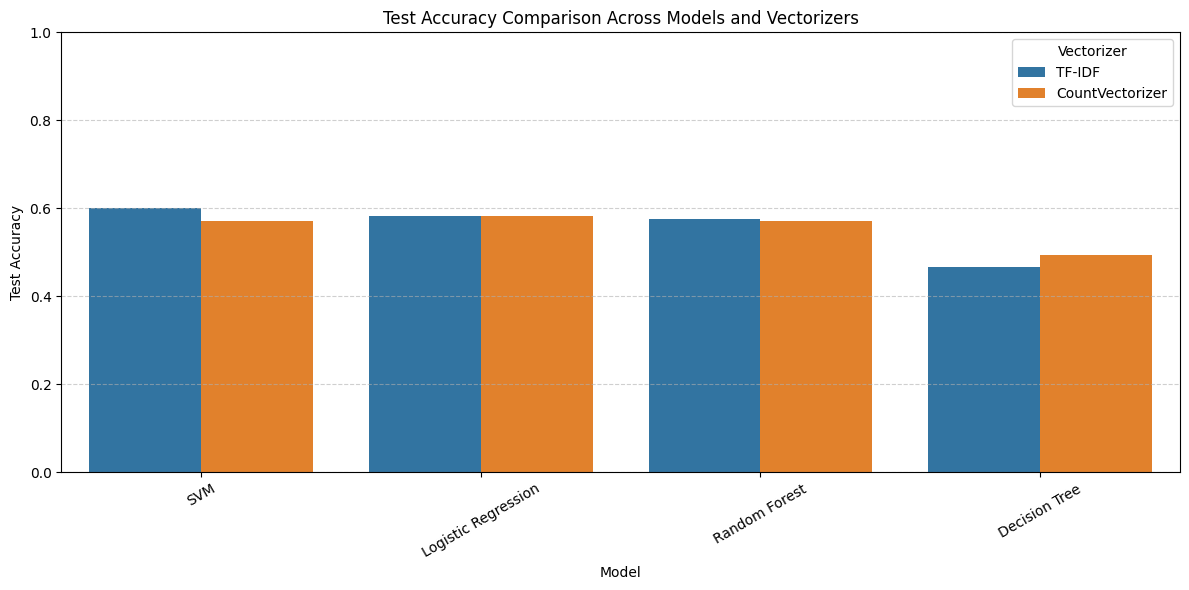

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set figure size
plt.figure(figsize=(12, 6))

# Bar plot
sns.barplot(
    data=results_df,
    x="Model",
    y="Accuracy",
    hue="Vectorizer"
)

# Formatting
plt.title("Test Accuracy Comparison Across Models and Vectorizers")
plt.xlabel("Model")
plt.ylabel("Test Accuracy")
plt.ylim(0, 1)
plt.xticks(rotation=30)
plt.legend(title="Vectorizer")
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

In [31]:
import os
import joblib

# Create folder
os.makedirs("models", exist_ok=True)

# Save all models (4 × 2 = 8 files)
for vec_name, models_dict in best_models.items():
    for model_name, model in models_dict.items():

        file_name = f"{model_name.replace(' ', '_').lower()}_{vec_name.lower()}.pkl"
        file_path = os.path.join("models", file_name)

        joblib.dump(model, file_path)
        print(f"Saved: {file_path}")

Saved: models/logistic_regression_countvectorizer.pkl
Saved: models/svm_countvectorizer.pkl
Saved: models/random_forest_countvectorizer.pkl
Saved: models/decision_tree_countvectorizer.pkl
Saved: models/logistic_regression_tf-idf.pkl
Saved: models/svm_tf-idf.pkl
Saved: models/random_forest_tf-idf.pkl
Saved: models/decision_tree_tf-idf.pkl


In [32]:
import joblib

# Save vectorizers
joblib.dump(count_vectorizer, "count_vectorizer.pkl")
joblib.dump(tfidf_vectorizer, "tfidf_vectorizer.pkl")

# Save label encoder
joblib.dump(label_encoder, "label_encoder.pkl")

print("Vectorizers and Label Encoder saved successfully.")

Vectorizers and Label Encoder saved successfully.


In [37]:
import joblib
import re
import string

# ------------------------------
# Load trained artifacts (MATCHED)
# ------------------------------
count_vectorizer = joblib.load("count_vectorizer.pkl")
label_encoder = joblib.load("label_encoder.pkl")

# Load trained SVM + CountVectorizer model
best_model = joblib.load("/content/models/svm_countvectorizer.pkl")

# ------------------------------
# Preprocessing Functions
# ------------------------------
NEGATIONS = {"not", "no", "never"}

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"@\w+|#\w+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\s+", " ", text).strip()
    return text

def handle_negation(text):
    words = text.split()
    result = []
    negate = False
    for w in words:
        if w in NEGATIONS:
            negate = True
            continue
        if negate:
            result.append("not_" + w)
            negate = False
        else:
            result.append(w)
    return " ".join(result)

# ------------------------------
# Rule Constants
# ------------------------------
POSITIVE = {"joy", "surprise"}
NEGATIVE_WORDS = {"sad", "angry", "fear", "upset", "mad", "depressed"}

def contains_negation(text):
    return any(w in NEGATIONS for w in text.lower().split())

# ------------------------------
# Prediction Function (MODEL + RULES)
# ------------------------------
def predict_emotion(text, vectorizer, model):
    clean = preprocess_text(text)
    clean_neg = handle_negation(clean)

    vec = vectorizer.transform([clean_neg])
    pred = model.predict(vec)[0]
    emotion = label_encoder.inverse_transform([pred])[0]

    words = clean.split()
    has_negation = contains_negation(text)

    # RULE 1: NEGATED NEGATIVE → NEUTRAL
    if has_negation and any(w in NEGATIVE_WORDS for w in words):
        return "neutral"

    # RULE 2: NEGATED POSITIVE → SADNESS
    if has_negation and emotion in POSITIVE:
        return "sadness"

    return emotion

# ------------------------------
# Test Predictions
# ------------------------------
tests = [
    "I am happy today",
    "I am not happy today",
    "I am sad today",
    "I am not sad today",
    "I am angry",
    "I am not angry",
    "I am not happy and not sad"
]

print("\nPREDICTIONS:\n")
for t in tests:
    print(f"{t} → {predict_emotion(t, count_vectorizer, best_model)}")



PREDICTIONS:

I am happy today → joy
I am not happy today → sadness
I am sad today → sadness
I am not sad today → neutral
I am angry → anger
I am not angry → neutral
I am not happy and not sad → neutral


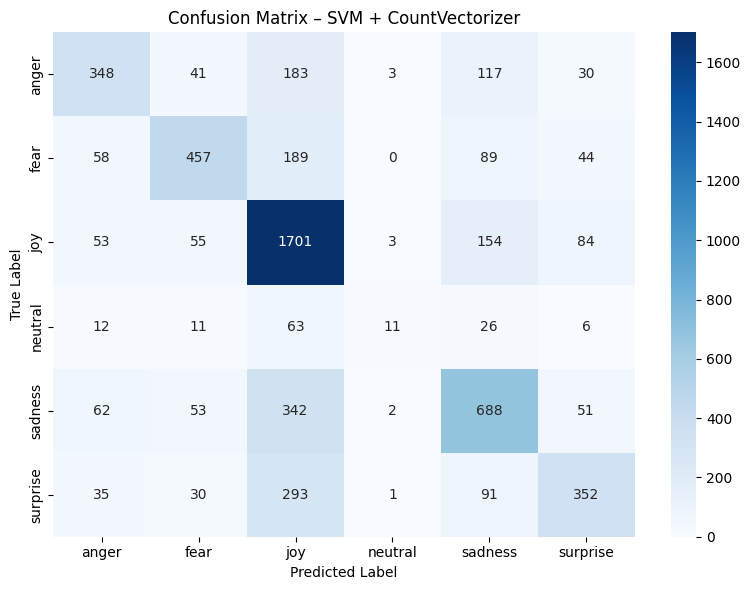

In [39]:
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ------------------------------
# Load trained artifacts
# ------------------------------
svm_count_model = joblib.load("/content/models/svm_countvectorizer.pkl")
label_encoder = joblib.load("label_encoder.pkl")

# ------------------------------
# Predict on test data
# ------------------------------
y_pred = svm_count_model.predict(X_test_count)

# ------------------------------
# Compute confusion matrix
# ------------------------------
cm = confusion_matrix(y_test, y_pred)

# ------------------------------
# Plot confusion matrix
# ------------------------------
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – SVM + CountVectorizer")
plt.tight_layout()
plt.show()

cv

        Vectorizer                Model  Accuracy  Macro Precision  \
5           TF-IDF                  SVM  0.599512         0.522430   
4           TF-IDF  Logistic Regression  0.581736         0.512371   
0  CountVectorizer  Logistic Regression  0.583304         0.509729   
1  CountVectorizer                  SVM  0.570931         0.490920   
2  CountVectorizer        Random Forest  0.571802         0.558453   
6           TF-IDF        Random Forest  0.575113         0.582095   
3  CountVectorizer        Decision Tree  0.493029         0.419105   
7           TF-IDF        Decision Tree  0.467410         0.402561   

   Macro Recall  Macro F1  
5      0.526640  0.523849  
4      0.546857  0.521408  
0      0.527814  0.514959  
1      0.488284  0.489185  
2      0.438573  0.469841  
6      0.436985  0.468569  
3      0.420817  0.417953  
7      0.407253  0.401967  


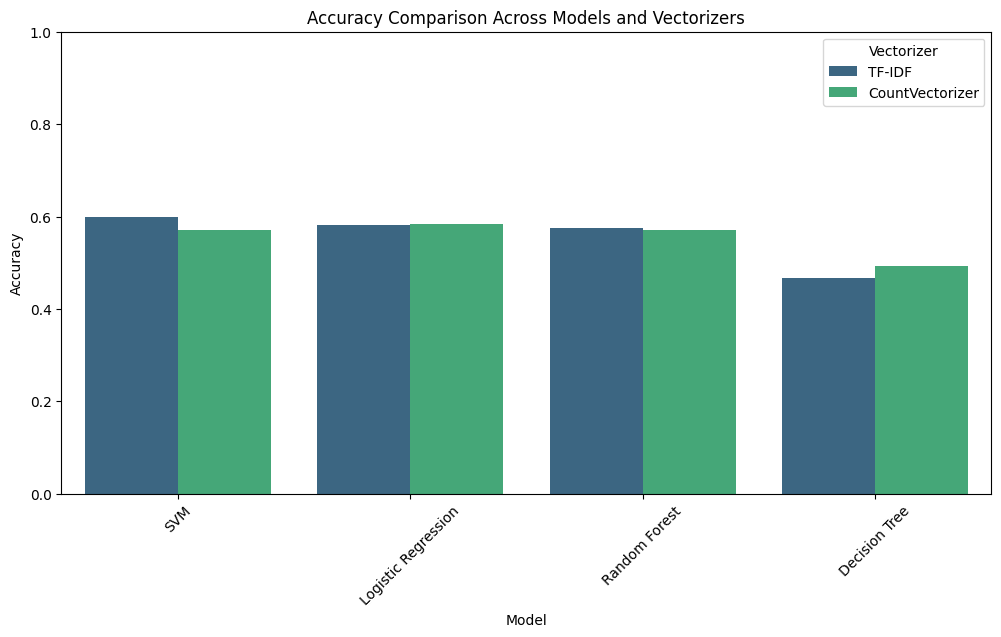

In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy

# Store metrics
all_results = []

# Loop over vectorizers
vectorizers_dict = {
    "CountVectorizer": count_vectorizer,
    "TF-IDF": tfidf_vectorizer
}

for vec_name, vectorizer in vectorizers_dict.items():
    # Transform training and test data
    X_train_vec = vectorizer.transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    for model_name, model in models.items():
        # Make a fresh copy of the model to avoid overwriting
        model_copy = copy.deepcopy(model)

        # Train model on the current vectorizer
        model_copy.fit(X_train_vec, y_train)

        # Predict
        y_pred = model_copy.predict(X_test_vec)

        # Metrics
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average="macro")
        rec = recall_score(y_test, y_pred, average="macro")
        f1 = f1_score(y_test, y_pred, average="macro")
        cm = confusion_matrix(y_test, y_pred)

        all_results.append({
            "Vectorizer": vec_name,
            "Model": model_name,
            "Accuracy": acc,
            "Macro Precision": prec,
            "Macro Recall": rec,
            "Macro F1": f1,
            "Confusion Matrix": cm
        })

# Results DataFrame
results_df = pd.DataFrame(all_results).sort_values("Macro F1", ascending=False)
print(results_df[["Vectorizer","Model","Accuracy","Macro Precision","Macro Recall","Macro F1"]])

# Accuracy plot
plt.figure(figsize=(12,6))
sns.barplot(
    x="Model",
    y="Accuracy",
    hue="Vectorizer",
    data=results_df,
    palette="viridis"
)
plt.title("Accuracy Comparison Across Models and Vectorizers")
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.legend(title="Vectorizer")
plt.show()

In [ ]:
import joblib

# ---- Save vectorizers ----
joblib.dump(count_vectorizer, "count_vectorizer.pkl")
joblib.dump(tfidf_vectorizer, "tfidf_vectorizer.pkl")

# ---- Save trained models ----
for model_name, model in models.items():
    filename = f"{model_name.replace(' ','_').lower()}.pkl"
    joblib.dump(model, filename)

# ---- Save label encoder ----
joblib.dump(label_encoder, "label_encoder.pkl")

print("All models, vectorizers, and label encoder saved successfully!")

In [ ]:
joblib.dump(count_vectorizer, "count_vectorizer.pkl")
count_vectorizer = joblib.load("count_vectorizer.pkl")

In [ ]:
from google.colab import files

# Download all saved files
files.download("count_vectorizer.pkl")
files.download("tfidf_vectorizer.pkl")
files.download("label_encoder.pkl")
for model_name in models.keys():
    filename = f"{model_name.replace(' ','_').lower()}.pkl"
    files.download(filename)

In [ ]:
import sklearn
print(sklearn.__version__)

for class imbalance:
The class imbalance problem: A systematic study
https://journals.sagepub.com/doi/abs/10.3233/IDA-2002-6504
Learning from Imbalanced Data
https://ieeexplore.ieee.org/document/5128907
1️⃣ What is Imbalance Ratio?

The imbalance ratio (IR) is defined as:

Imbalance Ratio
=
𝑁
majority
𝑁
minority
Imbalance Ratio=
N
minority
	​

N
majority
	​

	​


Where:

𝑁
majority
N
majority
	​

 = number of samples in the largest class

𝑁
minority
N
minority
	​

 = number of samples in the smallest class

It quantifies how skewed the dataset is.

IR = 1 → perfectly balanced dataset

IR > 1 → dataset is imbalanced

Source: He & Garcia, 2009, “Learning from Imbalanced Data”, IEEE Transactions on Knowledge and Data Engineering.

2️⃣ Typical Ranges and Interpretations

Different studies and guidelines suggest:

Imbalance Ratio (IR)	Interpretation	Action recommended
1 – 1.5	Slight imbalance	Usually negligible, standard training works
1.5 – 3	Moderate imbalance	Consider weighting or sampling methods
3 – 10	High imbalance	Use class weighting, stratified sampling, or resampling
10 – 50	Very high imbalance	Strongly recommended to resample (oversampling/undersampling)
>50	Extreme imbalance	Specialized algorithms required (SMOTE, ADASYN, cost-sensitive learning)

Sources:

He & Garcia, 2009, IEEE TKDE

Japkowicz & Stephen, 2002, The class imbalance problem: A systematic study

Chawla et al., 2002, SMOTE: Synthetic Minority Over-sampling Technique

3️⃣ What your dataset’s imbalance ratio (~7.21) means

Your majority class (joy) = 10,449

Your minority class (neutral) = 1,450

IR
=
10
,
449
/
1
,
450
≈
7.21
IR=10,449/1,450≈7.21

Interpretation:

This is high imbalance, but not extreme.

Classical ML models can still learn minority classes effectively if class weights are applied.

Oversampling/undersampling is optional but not strictly necessary.

Stratified sampling and class_weight="balanced" are sufficient to mitigate bias.

4️⃣ Practical guidelines

IR < 3 → generally safe, normal training

IR 3–10 → apply class weighting or stratified sampling (your case: 7.21)

IR 10–50 → strongly consider resampling (oversampling/undersampling)

IR > 50 → may require specialized imbalance-handling techniques

Your pipeline uses class_weight="balanced" + stratified split → appropriate for IR = 7.21.

5️⃣ Note on Multi-class Datasets

In multi-class datasets, IR is sometimes generalized as:

IR
max/min
=
max
⁡
𝑖
(
𝑁
𝑖
)
min
⁡
𝑖
(
𝑁
𝑖
)
IR
max/min
	​

=
min
i
	​

(N
i
	​

)
max
i
	​

(N
i
	​

)
	​


Some papers use mean imbalance ratio across classes, but the max/min method is widely accepted.

For your dataset, neutral vs joy gives the max/min ratio = 7.21 → consistent with high imbalance guidelines.

6️⃣ Summary for your report

“The dataset exhibits a high class imbalance (IR ≈ 7.21), with joy being the majority class and neutral the minority class. According to literature (He & Garcia, 2009; Japkowicz & Stephen, 2002), datasets with IR between 3–10 are considered highly imbalanced. In such cases, class weighting and stratified sampling are effective strategies to ensure that minority classes are properly learned, while oversampling is optional.”

References:

He, H., & Garcia, E. A. (2009). Learning from Imbalanced Data. IEEE Transactions on Knowledge and Data Engineering, 21(9), 1263–1284. doi:10.1109/TKDE.2009.191

Japkowicz, N., & Stephen, S. (2002). The class imbalance problem: A systematic study. Intelligent Data Analysis, 6(5), 429–449. doi:10.3233/IDA-2002-6504

Chawla, N. V., Bowyer, K. W., Hall, L. O., & Kegelmeyer, W. P. (2002). SMOTE: Synthetic Minority Over-sampling Technique. Journal of Artificial Intelligence Research, 16, 321–357. http://www.jair.org/media/953/live-953-2037-jair.pdf